<a href="https://colab.research.google.com/github/YuMan-Tam/deep-hedging-demo/blob/master/Colab/deep_hedging_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
#@title <font color='Blue'>**Overheads**</font>

# Author: Yu-Man Tam
# Last updated: 4/10/2020

# Reference: Deep Hedging (2019, Quantitative Finance) by Buehler et al.
# https://www.tandfonline.com/doi/abs/10.1080/14697688.2019.1571683

!apt-get update --fix-missing
!apt-get -qq install -y libquantlib0-dev
!pip -q install QuantLib tqdm>=4.45.0

%tensorflow_version 2.x

# Import custom modules from github
!rm -rf deep-hedging-demo
!git clone https://github.com/YuMan-Tam/deep-hedging-demo

import sys, os
sys.path.insert(0, os.getcwd() + "/deep-hedging-demo/lib")

from IPython.display import Math, HTML, clear_output

import numpy as np
import QuantLib as ql
import tensorflow as tf
from scipy.stats import norm

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, \
                                            ReduceLROnPlateau
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

from stochastic_processes import BlackScholesProcess
from instruments import European_Call
from deep_hedging import Deep_Hedging_Model
from loss_metrics import Loss, Entropy, CVaR
from utilities import train_test_split

%load_ext autoreload

clear_output()
print("\nFinish installing and importing all necessary libraries!")


Finish installing and importing all necessary libraries!


**Import all neccessary python, quantitative finance, and machine learning software libraries.**

In [0]:
#@title <font color='Blue'>**User Inputs**</font>

# Geometric Brownian Motion.
N = 30 # Number of time steps (in days)

S0 = 100.0 # Stock price at time = 0
sigma = 0.2 # Implied volatility
risk_free = 0.0 # Risk-free rate
dividend = 0.0 # Continuous dividend yield

Ktrain = 1*(10**5) # Size of training sample.
Ktest_ratio = 0.2 # Fraction of training sample as testing sample.

# European call option (short).
strike = S0
payoff_func = lambda x: -np.maximum(x - strike, 0.0)
calculation_date = ql.Date.todaysDate()
maturity_date = ql.Date.todaysDate() + N

# Day convention.
day_count = ql.Actual365Fixed() # Actual/Actual (ISDA)

# Proportional transaction cost.
epsilon = np.power(2.0,-8)*0.0                 

# Information set (in string)
# Choose from: S, log_S, normalized_log_S (by S0)
information_set = "normalized_log_S"

# Loss function
# loss_type = "CVaR" (Expected Shortfall) -> loss_param = alpha 
# loss_type = "Entropy" -> loss_param = lambda
loss_type = "Entropy"
loss_param = 1.0

# Neural network (NN) structure
m = 15 # Number of neurons in each hidden layer.
d = 3 # Number of hidden layers (Note including input nor output layer)         

# Neural network training parameters
lr = 1e-2 # Learning rate
batch_size=256 # Batch size
epochs=50 # Number of epochs

# Other parameters
use_batch_norm = False
kernel_initializer = "he_uniform"

activation_dense = "leaky_relu"
activation_output = "sigmoid"
final_period_cost = False

# Other control flags for development purpose.
mc_simulator = "QuantLib" # "QuantLib" or "Numpy"


**Provide input parameters for Monte Carlo simulation, call option, transaction cost, loss function, and deep hedging algorithm.**

In [0]:
#@title <font color='Blue'>**Monte Carlo Simulation - Generate Random Paths of Stock Prices**</font>
%autoreload 2

seed = 0 # Random seed. Change to have deterministic outcome.

# Total obs = Training + Testing
nobs = int(Ktrain*(1+Ktest_ratio)) 
		
# Length of one time-step (as fraction of a year).
dt = day_count.yearFraction(calculation_date,calculation_date + 1) 
maturity = N*dt # Maturities (in the unit of a year)

stochastic_process = BlackScholesProcess(s0 = S0, sigma = sigma, risk_free = risk_free, \
                        dividend = dividend, day_count = day_count, seed=seed)

S = stochastic_process.gen_path(maturity, N, nobs)

clear_output()

print("\n\ns0 = " + str(S0))
print("sigma = " + str(sigma))
print("risk_free = " + str(risk_free) + "\n")
print("Number of time steps = " + str(N))
print("Length of each time step = " + "1/365\n")
print("Simulation Done!")

In [61]:
#@title <font color='Blue'>**Prepare data to be fed into the deep hedging algorithm.**</font>

payoff_T = payoff_func(S[:,-1]) # Payoff of the call option

trade_set =  np.stack((S),axis=1) # Trading set

if information_set is "S":
  I =  np.stack((S),axis=1) # Information set
elif information_set is "log_S":
  I =  np.stack((np.log(S)),axis=1)
elif information_set is "normalized_log_S":
  I =  np.stack((np.log(S/S0)),axis=1)

# Structure of xtrain:
#   1) Trade set: [S]
#   2) Information set: [S] 
#   3) payoff (dim = 1)
x_all = []
for i in range(N+1):
  x_all += [trade_set[i,:,None]]
  if i != N:
    x_all += [I[i,:,None]]
x_all += [payoff_T[:,None]]

# Split the entire sample into a training sample and a testing sample.
test_size = int(Ktrain*Ktest_ratio)
[xtrain, xtest] = train_test_split(x_all, test_size=test_size)
[S_train, S_test] = train_test_split([S], test_size=test_size)
[option_payoff_train, option_payoff_test] = \
    train_test_split([x_all[-1]], test_size=test_size)

print("Finish preparing data!")

Finish preparing data!


In [62]:
#@title <font color='Blue'>**Run the Deep Hedging Algorithm (Simple Network)!**</font>
optimizer = Adam(learning_rate=lr)

# Setup and compile the model
model_simple = Deep_Hedging_Model(N=N, d=d+2, m=m, risk_free=risk_free, \
          dt = dt, strategy_type="simple", epsilon = epsilon, \
          use_batch_norm = use_batch_norm, kernel_initializer = kernel_initializer, \
          activation_dense = activation_dense, activation_output = activation_output, \
          final_period_cost = final_period_cost, output_type="colab", \
          loss_type=loss_type, loss_param=loss_param)

loss = Loss("Entropy", model_simple.output, loss_param)
model_simple.add_loss(loss)

model_simple.compile(optimizer=optimizer)

early_stopping = EarlyStopping(monitor="loss", \
          patience=10, min_delta=1e-4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="loss", \
          factor=0.5, patience=2, min_delta=1e-3, verbose=0)

callbacks = [early_stopping, reduce_lr]

# Fit the model.
model_simple.fit(x=xtrain, batch_size=batch_size, epochs=epochs, \
          validation_data=xtest, verbose=1)

clear_output()
print("Finished running deep hedging algorithm! (Simple Network)")

Finished running deep hedging algorithm! (Simple Network)


In [63]:
#@title <font color='Blue'>**Run the Deep Hedging Algorithm (Recurrent Network)!**</font>
optimizer = Adam(learning_rate=lr)

# Setup and compile the model
model_recurrent = Deep_Hedging_Model(N=N, d=d+2, m=m, risk_free=risk_free, \
          dt = dt, strategy_type="recurrent", epsilon = epsilon, \
          use_batch_norm = use_batch_norm, kernel_initializer = kernel_initializer, \
          activation_dense = activation_dense, activation_output = activation_output, \
          final_period_cost = final_period_cost, output_type="colab", \
          loss_type=loss_type, loss_param=loss_param)

loss = Loss("Entropy", model_recurrent.output, loss_param)
model_recurrent.add_loss(loss)

model_recurrent.compile(optimizer=optimizer)

early_stopping = EarlyStopping(monitor="loss", \
          patience=10, min_delta=1e-4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="loss", \
          factor=0.5, patience=2, min_delta=1e-3, verbose=0)

callbacks = [early_stopping, reduce_lr]

# Fit the model.
model_recurrent.fit(x=xtrain, batch_size=batch_size, epochs=epochs, \
          validation_data=xtest, verbose=1)

clear_output()
print("Finished running deep hedging algorithm! (Simple Network)")

Finished running deep hedging algorithm! (Simple Network)


In [64]:
#@title <font color='Blue'>**Results: Option Prices**</font>
call = European_Call()

price_BS = call.get_BS_price(S = S_test[0], sigma = sigma, \
              risk_free = risk_free, dividend = dividend, K = strike, \
              exercise_date = maturity_date, \
              calculation_date = calculation_date, \
              day_count = day_count, dt = dt)
delta_BS = call.get_BS_delta(S = S_test[0], sigma = sigma, \
              risk_free = risk_free, dividend = dividend, K = strike, \
              exercise_date = maturity_date, \
              calculation_date = calculation_date, 
              day_count = day_count, dt = dt)

PnL_BS =  call.get_BS_PnL(S= S_test[0], \
              payoff= payoff_func(S_test[0][:,-1]), delta=delta_BS, \
              dt= dt, risk_free = risk_free, \
              final_period_cost=final_period_cost, epsilon=epsilon)

risk_neutral_price = \
    -option_payoff_test[0].mean()*np.exp(-risk_free*(N*dt))
nn_simple_price = model_simple.evaluate(xtest, batch_size=test_size, verbose=0)
nn_recurrent_price = model_recurrent.evaluate(xtest, batch_size=test_size, verbose=0)

print("The Black-Scholes model price is %2.3f." % price_BS[0][0])
print("The Risk Neutral price is %2.3f." % risk_neutral_price)
print("The Deep Hedging (with simple network) price is %2.3f." % nn_simple_price)
print("The Deep Hedging (with recurrent network) price is %2.3f." % nn_recurrent_price)

The Black-Scholes model price is 2.287.
The Risk Neutral price is 2.300.
The Deep Hedging (with simple network) price is 2.365.
The Deep Hedging (with recurrent network) price is 2.362.


In [0]:
#@title <font color='Blue'>**Results: Black-Scholes PnL vs Deep Hedging PnL**</font>
bar1 = PnL_BS + price_BS[0][0]
bar2 = model_simple(xtest).numpy().squeeze() + price_BS[0][0]

# Plot Black-Scholes PnL and Deep Hedging PnL (with BS_price charged on both).
fig_PnL = plt.figure(dpi= 125, facecolor='w')
fig_PnL.suptitle("Black-Scholes PnL vs Deep Hedging PnL \n", \
      fontweight="bold")
ax = fig_PnL.add_subplot()
ax.set_title("Simple Network Structure with epsilon = " + str(epsilon), \
      fontsize=8)
ax.set_xlabel("PnL")
ax.set_ylabel("Frequency")
ax.hist((bar1,bar2), bins=30, \
          label=["Black-Scholes PnL", "Deep Hedging PnL"])
ax.legend()
plt.show()

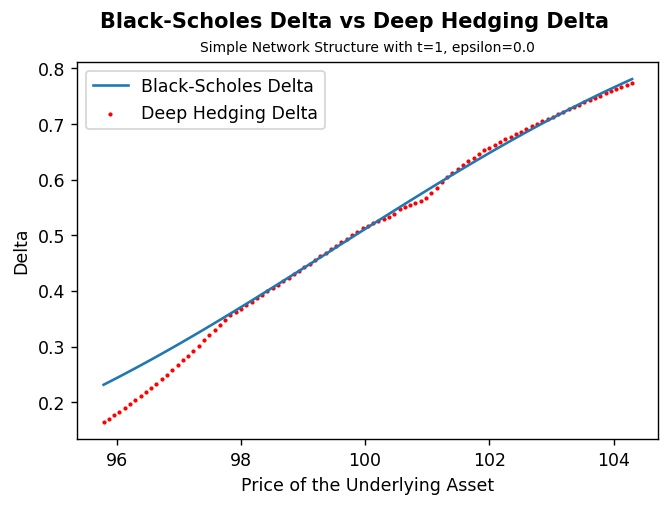

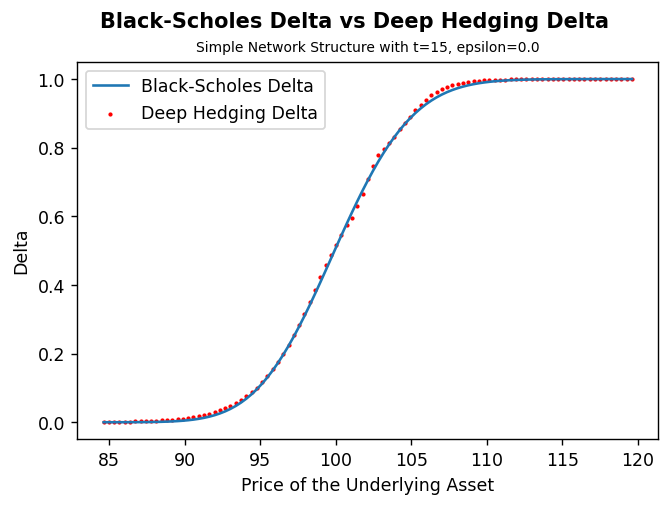

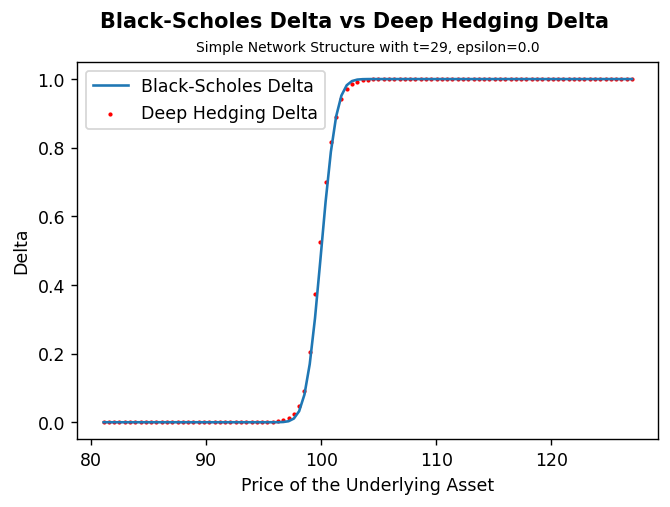

In [67]:
#@title <font color='Blue'>**Results: Black-Scholes Delta vs Deep Hedging Delta.**</font>
for days_from_today in (1,15,29):
  tau = (N-days_from_today)*dt
    
  min_S = S_test[0][:,days_from_today].min()
  max_S = S_test[0][:,days_from_today].max()
  S_range = np.linspace(min_S,max_S,101)

  # Attention: Need to transform it to be consistent with the information set.
  if information_set is "S":
    I_range =  S_range # Information set
  elif information_set is "log_S":
    I_range =  np.log(S_range)
  elif information_set is "normalized_log_S":
    I_range =  np.log(S_range/S0)        
      
  # Compute Black-Scholes delta for S_range.
  # Reference: https://en.wikipedia.org/wiki/Greeks_(finance)
  d1 = (np.log(S_range) - np.log(strike) + \
        (risk_free - dividend + (sigma**2)/2)*tau) \
              / (sigma*np.sqrt(tau))  
                
  model_delta = norm.cdf(d1)*np.exp(-dividend*tau)

  submodel = Model(model_simple.get_layer("dense_0_" + \
        str(days_from_today)).input, \
        model_simple.get_layer("delta_" + \
        str(days_from_today)).output)
  nn_delta = submodel(I_range)

  # Create a plot of Black-Scholes delta against deep hedging delta.
  fig_delta = plt.figure(dpi= 125, facecolor='w')
  fig_delta.suptitle("Black-Scholes Delta vs Deep Hedging Delta \n", \
        fontweight="bold")
  ax_delta = fig_delta.add_subplot()
  ax_delta.set_title("Simple Network Structure with " + \
              "t=" + str(days_from_today) + ", " + \
                "epsilon=" + str(epsilon), \
                fontsize=8)
  ax_delta.set_xlabel("Price of the Underlying Asset")
  ax_delta.set_ylabel("Delta")
  ax_delta.plot(S_range, model_delta, label="Black-Scholes Delta")
  ax_delta.scatter(S_range,nn_delta, c="red", s=2, label="Deep Hedging Delta")
  ax_delta.legend()
  plt.show()

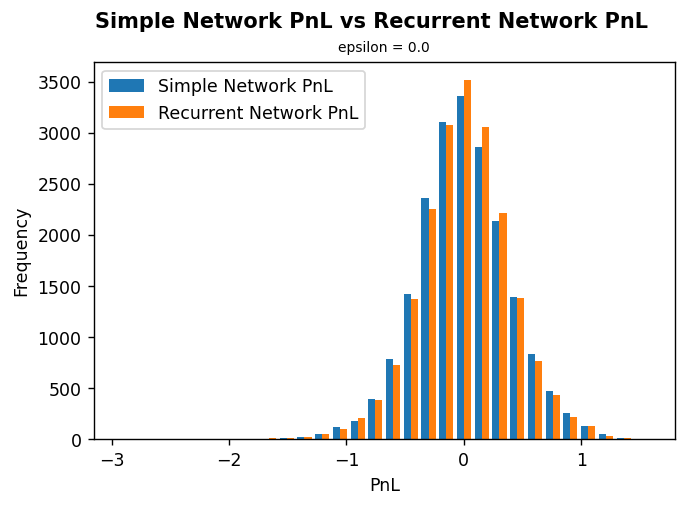

In [69]:
#@title <font color='Blue'>**Results: Simple vs Recurrent Network**</font>
bar1 = model_simple(xtest).numpy().squeeze() + price_BS[0][0]
bar2 = model_recurrent(xtest).numpy().squeeze() + price_BS[0][0]

# Plot Simple Network PnL vs Recurrent Network PnL (with BS_price charged on both).
fig_nn = plt.figure(dpi= 125, facecolor='w')
fig_nn.suptitle("Simple Network PnL vs Recurrent Network PnL \n ", \
      fontweight="bold")
ax = fig_nn.add_subplot()
ax.set_title("epsilon = " + str(epsilon), fontsize=8)
ax.set_xlabel("PnL")
ax.set_ylabel("Frequency")
ax.hist((bar1,bar2), bins=30, \
      label=["Simple Network PnL", "Recurrent Network PnL"])
ax.legend()
plt.show()